# Lab 3: Generating Data

Based on assignments by Lisa Zhang and Jimmy Ba.

In this lab, you will build models to perform image colourization. That is, given a greyscale image, we wish to predict the colour at each pixel. Image colourization is a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings.

To keep the training time manageable we will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. The data loading script is included with the notebooks, and should download automatically the first time it is loaded. 

We will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part of the assignment we will compare the autoencoder approach to conditional generative adversarial networks (cGANs).

In the process, you are expected to learn to:

1. Clean and process the dataset and create greyscale images.
2. Implement and modify an autoencoder architecture.
3. Tune the hyperparameters of an autoencoder.
4. Implement skip connections and other techniques to improve performance.
5. Implement a cGAN and compare with an autoencoder.
6. Improve on the cGAN by trying one of several techniques to enhance training.


### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/14eUVLNz3KeZYdYnGmHrRN-i8fnShFshi/view?usp=sharing

# PART A - Autoencoder [20 pt]

In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data. Note that you will need to use the Colab GPU for this assignment.

In [ ]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3

/content/a3


In [ ]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz
Extracting file.


## Part 1. Data Preparation [7 pt]

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks. 

### Part (a) [1pt]
Verify that the dataset has loaded correctly. How many samples do we have? How is the data organized?

In [ ]:
# code to examine the dataset
print(len(m)) # tuple
print(len(m[0])) # Train
print(len(m[1])) # Test
print(m[0][0].shape) # x_train
print(m[0][1].shape) # y_train
print(m[1][0].shape) # x_test
print(m[1][1].shape) # y_test
# Inside m, there are two terms (tuple), the first term stores all the train data 
# (50000 samples), the second term stores all the test data (10000 samples). 
# Inside train/test data, there are also two terms(tuple), the first term stores 
# the colored images/x data (32x32 size), the second term stores the label/y data 
# (dimension = 1). 

2
2
2
(50000, 3, 32, 32)
(50000, 1)
(10000, 3, 32, 32)
(10000, 1)


### Part (b) [2pt]
Preprocess the data to select only images of horses. Learning to generate only hourse images will make our task easier. Your function will also convert the colour images to greyscale to create our input data.

In [ ]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


### Part (c) [2pt]
Create a dataloader (or function) to batch the samples.

In [ ]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)

### Part (e) [2pt]
Verify and visualize that we are able to generate different batches of data.

In [ ]:
# code to load different batches of horse dataset

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)


Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...


In [ ]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [ ]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (5000, 3, 32, 32) (5000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches

In [ ]:
# obtain batches of images
xs, ys = next(iter(get_batch(train_grey, train_rgb, 10)))
print(xs.shape, ys.shape)

(10, 1, 32, 32) (10, 3, 32, 32)


Visualization

(10, 1, 32, 32) (10, 3, 32, 32)


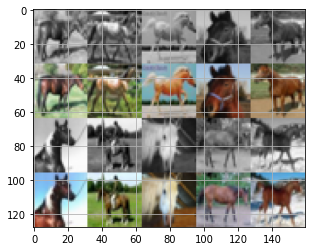

In [ ]:
# visualize 5 train/test images
xs_test, ys_test = next(iter(get_batch(test_grey, test_rgb, 10)))
print(xs_test.shape, ys_test.shape)

traingrey = np.transpose(xs[:5,:,:,:], [0,2,3,1])
trainrgb = np.transpose(ys[:5,:,:,:], [0,2,3,1])
testgrey = np.transpose(xs_test[:5,:,:,:], [0,2,3,1])
testrgb = np.transpose(ys_test[:5,:,:,:], [0,2,3,1])

img = np.vstack([
      np.hstack(np.tile(traingrey, [1,1,1,3])), # first row - grey train images
      np.hstack(trainrgb), # second row - colored train images
      np.hstack(np.tile(testgrey, [1,1,1,3])), # third row - grey test images
      np.hstack(testrgb)]) # fourth row - colored test images

plt.grid('off')
plt.imshow(img, vmin=0., vmax=1.)
plt.show()

## Part 2. Colourization as Regression [5 pt]

There are many ways to frame the problem of image colourization as a machine learning problem. One naive approach is to frame it as a regression problem, where we build a model to predict the RGB intensities at each pixel given the greyscale input. In this case, the outputs are continuous, and so squared error can be used to train the model.

In this section, you will get familar with training neural networks using cloud GPUs. Run the helper code and answer the questions that follow.

#### Helper Code

Regression Architecture

In [ ]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

Training code

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        
        print(epoch, loss.cpu().detach())
        # if args.plot:
        #   visual(images, labels, outputs, args.gpu, 1)
        if epoch == args['epochs']-1:
            visual(images, labels, outputs, args.gpu, 1)
    
    return gen

Training visualization code

In [ ]:
# visualize 5 train/test images
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

Main training loop for regression CNN

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 tensor(0.0652)
1 tensor(0.0236)
2 tensor(0.0178)
3 tensor(0.0159)
4 tensor(0.0148)
5 tensor(0.0139)
6 tensor(0.0133)
7 tensor(0.0128)
8 tensor(0.0124)
9 tensor(0.0120)
10 tensor(0.0116)
11 tensor(0.0113)
12 tensor(0.0111)
13 tensor(0.0108)
14 tensor(0.0106)
15 tensor(0.0104)
16 tensor(0.0103)
17 tensor(0.0101)
18 tensor(0.0099)
19 tensor(0.0098)
20 tensor(0.0097)
21 tensor(0.0095)
22 tensor(0.0094)
23 tensor(0.0093)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0092)


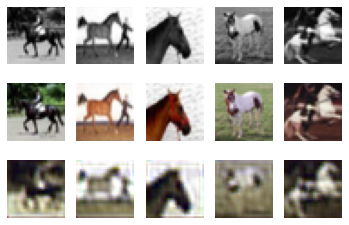

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

### Part (a) [1 pt]
Describe the model RegressionCNN. How many convolution layers does it have? What are the filter sizes and number of filters at each layer? Construct a table or draw a diagram.

Answer: It has a total of 6 convolution layers.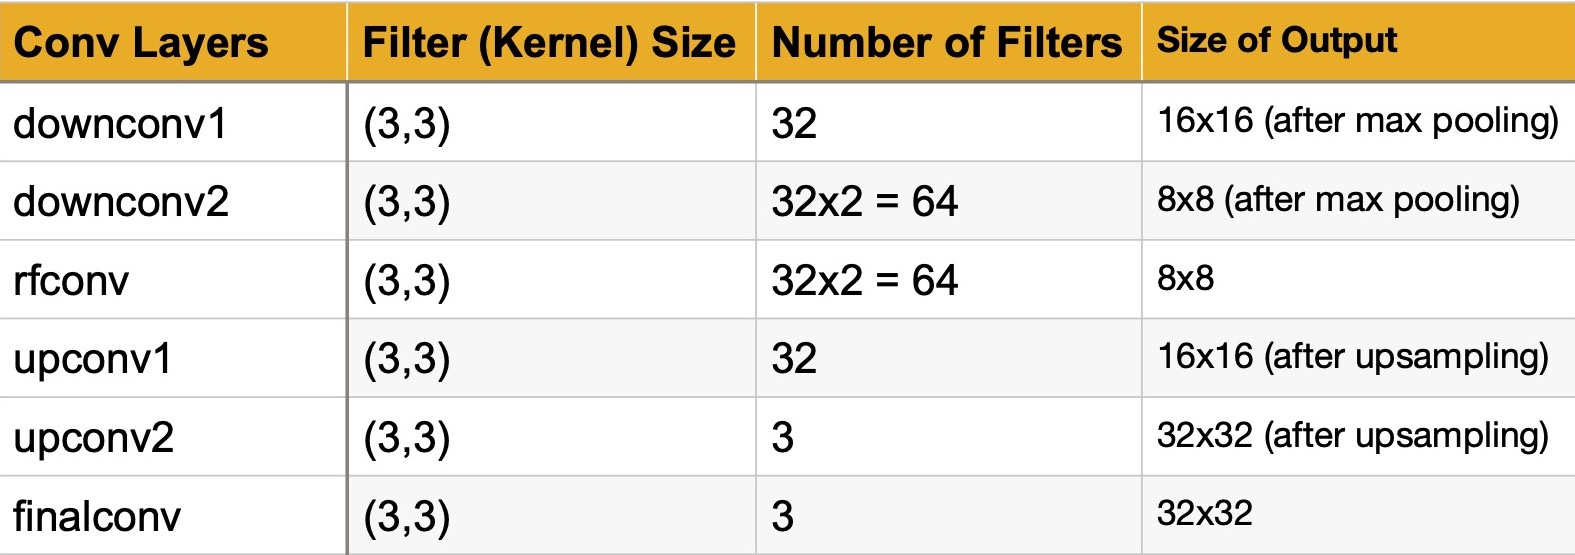

### Part (b) [1 pt]
Run the regression training code (should run without errors). This will generate some images. How many epochs are we training the CNN model in the given setting?

Answer: 25 epochs are trained in the given setting. (final loss = 0.0092)

### Part (c) [3 pt]
Re-train a couple of new models using a different number of training epochs. You may train each new models in a new code cell by copying and modifying the code from the last notebook cell. Comment on how the results (output images, training loss) change as we increase or decrease the number of epochs.

Answer:
As number of epochs increase, performance become better (loss becomes lower).
*   10 epochs: color boundary is more blurry between dark and light colors, training loss only reached to 0.0101.
*   50 epochs, reconstructed imags were closer to the original image, training loss reached to 0.0074.
*   100 epochs, color boundary is clear to capture individual object with its color. It is even closer to the original image's color composition, training loss reached to 0.0062.

#### Epochs = 10 (final loss = 0.0101)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0897)
1 tensor(0.0246)
2 tensor(0.0166)
3 tensor(0.0144)
4 tensor(0.0132)
5 tensor(0.0123)
6 tensor(0.0116)
7 tensor(0.0110)
8 tensor(0.0105)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9 tensor(0.0101)


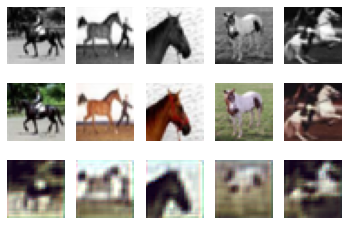

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 10,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

#### Epochs = 50 (final loss = 0.0074)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0517)
1 tensor(0.0221)
2 tensor(0.0170)
3 tensor(0.0151)
4 tensor(0.0139)
5 tensor(0.0131)
6 tensor(0.0126)
7 tensor(0.0122)
8 tensor(0.0119)
9 tensor(0.0115)
10 tensor(0.0112)
11 tensor(0.0109)
12 tensor(0.0106)
13 tensor(0.0104)
14 tensor(0.0103)
15 tensor(0.0101)
16 tensor(0.0100)
17 tensor(0.0098)
18 tensor(0.0096)
19 tensor(0.0094)
20 tensor(0.0093)
21 tensor(0.0091)
22 tensor(0.0090)
23 tensor(0.0089)
24 tensor(0.0088)
25 tensor(0.0087)
26 tensor(0.0087)
27 tensor(0.0086)
28 tensor(0.0085)
29 tensor(0.0084)
30 tensor(0.0084)
31 tensor(0.0083)
32 tensor(0.0082)
33 tensor(0.0082)
34 tensor(0.0081)
35 tensor(0.0081)
36 tensor(0.0080)
37 tensor(0.0080)
38 tensor(0.0079)
39 tensor(0.0079)
40 tensor(0.0078)
41 tensor(0.0078)
42 tensor(0.0077)
43 tensor(0.0077)
44 tensor(0.0076)
45 tensor(0.0076)
46 tensor(0.0075)
47 tensor(0.0075)
48 tensor(0.0075)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49 tensor(0.0074)


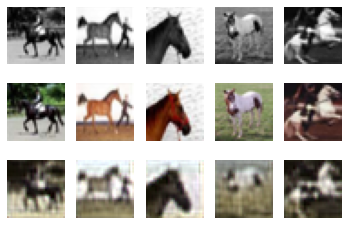

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 50,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

#### Epochs = 100 (final loss = 0.0062)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0800)
1 tensor(0.0267)
2 tensor(0.0223)
3 tensor(0.0196)
4 tensor(0.0176)
5 tensor(0.0159)
6 tensor(0.0146)
7 tensor(0.0136)
8 tensor(0.0129)
9 tensor(0.0124)
10 tensor(0.0119)
11 tensor(0.0115)
12 tensor(0.0112)
13 tensor(0.0109)
14 tensor(0.0106)
15 tensor(0.0103)
16 tensor(0.0101)
17 tensor(0.0099)
18 tensor(0.0097)
19 tensor(0.0095)
20 tensor(0.0093)
21 tensor(0.0092)
22 tensor(0.0090)
23 tensor(0.0089)
24 tensor(0.0088)
25 tensor(0.0087)
26 tensor(0.0086)
27 tensor(0.0085)
28 tensor(0.0085)
29 tensor(0.0084)
30 tensor(0.0083)
31 tensor(0.0082)
32 tensor(0.0082)
33 tensor(0.0081)
34 tensor(0.0081)
35 tensor(0.0080)
36 tensor(0.0079)
37 tensor(0.0079)
38 tensor(0.0078)
39 tensor(0.0078)
40 tensor(0.0077)
41 tensor(0.0077)
42 tensor(0.0076)
43 tensor(0.0076)
44 tensor(0.0075)
45 tensor(0.0075)
46 tensor(0.0074)
47 tensor(0.0074)
48 tensor(0.0074)
49 tensor(0.0073)
50 tens

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99 tensor(0.0062)


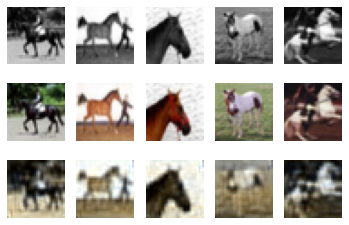

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 100,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

## Part 3. Skip Connections [8 pt]
A skip connection in a neural network is a connection which skips one or more layer and connects to a later layer. We will introduce skip connections.

### Part (a) [4 pt]
Add a skip connection from the first layer to the last, second layer to the second last, etc.
That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [3], and is called a "UNet". Following the CNN class that you have completed, complete the __init__ and forward methods of the UNet class.
Hint: You will need to use the function torch.cat.

In [ ]:
#complete the code

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_colours, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(num_colours + num_in_channels, num_colours, kernel_size=kernel, padding=padding)
        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        out1 = self.downconv1(x)
        out2 = self.downconv2(out1)
        out3 = self.rfconv(out2)
        out4 = self.upconv1(torch.cat((out2, out3),1))
        out5 = self.upconv2(torch.cat((out1, out4),1))
        out = self.finalconv(torch.cat((x, out5),1))
        ###################################################
        return out

### Part (b) [2 pt]
Train the "UNet" model for the same amount of epochs as the previous CNN and plot the training curve using a batch size of 100. How does the result compare to the previous model? Did skip connections improve the validation loss and accuracy? Did the skip connections improve the output qualitatively? How? Give at least two reasons why skip connections might improve the performance of our CNN models.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0195)
1 tensor(0.0123)
2 tensor(0.0103)
3 tensor(0.0093)
4 tensor(0.0086)
5 tensor(0.0081)
6 tensor(0.0076)
7 tensor(0.0073)
8 tensor(0.0070)
9 tensor(0.0068)
10 tensor(0.0065)
11 tensor(0.0063)
12 tensor(0.0061)
13 tensor(0.0059)
14 tensor(0.0058)
15 tensor(0.0056)
16 tensor(0.0055)
17 tensor(0.0054)
18 tensor(0.0053)
19 tensor(0.0052)
20 tensor(0.0051)
21 tensor(0.0050)
22 tensor(0.0050)
23 tensor(0.0049)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0048)


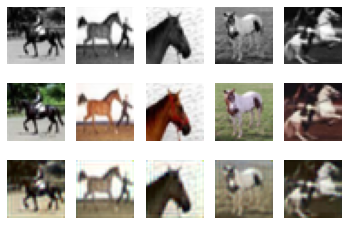

In [ ]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

# Previous RegressionCNN with 25 epochs reached 0.0092 loss. With skip 
# connections, the result reached 0.0048 loss (better and faster 11s). 
# With Skip connections, the boundary different different colors in the images 
# became more clear and sharp. Previous model's color boundaries in images were 
# more blurry. The color is closer to the original color set.

# 1） Skipping simplifies the network, using fewer layers in the initial 
# training stages. This training/learning speeds are faster and reduces the impact 
# of vanishing gradients as it has fewer layers to propagate through.
# 2) It also helps precondition the problem, so the model become easier to learn 
# a new function given a reference as a comparison to the identity mapping rather 
# than to learning everything from scratch.

### Part (c) [2 pt]
Re-train a few more "UNet" models using different mini batch sizes with a fixed number of epochs. Describe the effect of batch sizes on the training/validation loss, and the final image output.

As the batch size becomes smaller, the Unet learns the colorization extremely well, but it also took longer time to learn. 

*   With batch size = 5, it took 1m53s to  with 25 epochs, the loss reaches to 0.0019. The resulted images are almost exactly the same color as the original rgb images. When the loss reaches to 0.0020, the loss starts to fluctuate between 0.0021 and 0.0019 (probably reaches its limit).

*   Batch size = 10 and 20 had loss = 0.0022 and 0.0028, the colorization also reached very well and close to the original color.

*   With batch size = 50, it took 14s to train with 25 epochs, final loss = 0.0043. It has slightly worse performance than the result with smaller batch size.

#### Batch size = 5 (time = 1m53s, final loss = 0.0019)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0055)
1 tensor(0.0038)
2 tensor(0.0032)
3 tensor(0.0029)
4 tensor(0.0027)
5 tensor(0.0027)
6 tensor(0.0026)
7 tensor(0.0026)
8 tensor(0.0025)
9 tensor(0.0024)
10 tensor(0.0022)
11 tensor(0.0020)
12 tensor(0.0022)
13 tensor(0.0021)
14 tensor(0.0020)
15 tensor(0.0021)
16 tensor(0.0021)
17 tensor(0.0020)
18 tensor(0.0020)
19 tensor(0.0019)
20 tensor(0.0020)
21 tensor(0.0019)
22 tensor(0.0021)
23 tensor(0.0019)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0019)


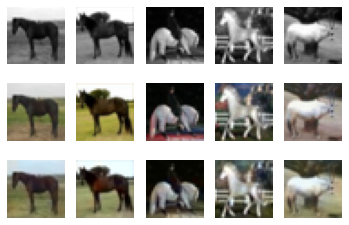

In [ ]:
# complete the code
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 5,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

#### Batch size = 10 (time = 57s, final loss = 0.0022)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0060)
1 tensor(0.0047)
2 tensor(0.0041)
3 tensor(0.0037)
4 tensor(0.0035)
5 tensor(0.0034)
6 tensor(0.0032)
7 tensor(0.0031)
8 tensor(0.0030)
9 tensor(0.0029)
10 tensor(0.0029)
11 tensor(0.0027)
12 tensor(0.0027)
13 tensor(0.0026)
14 tensor(0.0025)
15 tensor(0.0024)
16 tensor(0.0024)
17 tensor(0.0024)
18 tensor(0.0023)
19 tensor(0.0023)
20 tensor(0.0023)
21 tensor(0.0023)
22 tensor(0.0023)
23 tensor(0.0022)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0022)


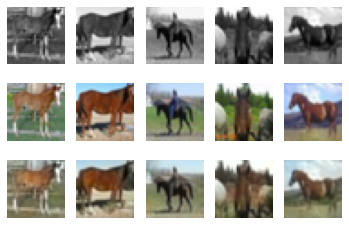

In [ ]:
# complete the code
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 10,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

#### Batch size = 20 (time = 29s, final loss = 0.0028)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0095)
1 tensor(0.0072)
2 tensor(0.0060)
3 tensor(0.0054)
4 tensor(0.0050)
5 tensor(0.0047)
6 tensor(0.0044)
7 tensor(0.0042)
8 tensor(0.0040)
9 tensor(0.0038)
10 tensor(0.0037)
11 tensor(0.0036)
12 tensor(0.0035)
13 tensor(0.0035)
14 tensor(0.0034)
15 tensor(0.0033)
16 tensor(0.0033)
17 tensor(0.0032)
18 tensor(0.0031)
19 tensor(0.0031)
20 tensor(0.0030)
21 tensor(0.0029)
22 tensor(0.0029)
23 tensor(0.0028)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0028)


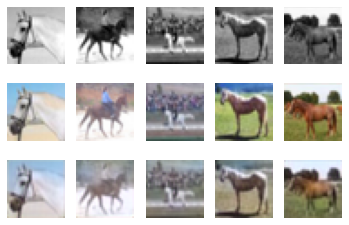

In [ ]:
# complete the code
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 20,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

#### Batch size = 50 (time = 14s, final loss = 0.0043)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0156)
1 tensor(0.0119)
2 tensor(0.0102)
3 tensor(0.0091)
4 tensor(0.0083)
5 tensor(0.0078)
6 tensor(0.0073)
7 tensor(0.0070)
8 tensor(0.0067)
9 tensor(0.0065)
10 tensor(0.0062)
11 tensor(0.0061)
12 tensor(0.0058)
13 tensor(0.0057)
14 tensor(0.0055)
15 tensor(0.0054)
16 tensor(0.0052)
17 tensor(0.0051)
18 tensor(0.0050)
19 tensor(0.0049)
20 tensor(0.0048)
21 tensor(0.0047)
22 tensor(0.0045)
23 tensor(0.0044)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24 tensor(0.0043)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


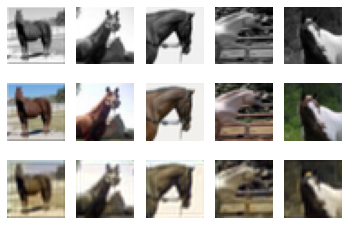

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

# PART B - Conditional GAN [30 pt]

In this second half of the assignment we will construct a conditional generative adversarial network for our image colourization task.

## Part 1. Conditional GAN [15 pt]

To start we will be modifying the previous sample code to construct and train a conditional GAN. We will exploring the different architectures to identify and select our best image colourization model.

Note: This second half of the assignment should be started after the lecture on generative adversarial networks (GANs). 


### Part (a) [3 pt]
Modify the provided training code to implement a generator. Then test to verify it works on the desired input (Hint: you can reuse some of your earlier autoencoder models here to act as a generator)

In [ ]:
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ###############
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_colours, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(num_colours + num_in_channels, 3, kernel_size=kernel, padding=padding) 
        # make sure it always return rbg image
        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        out1 = self.downconv1(x)
        out2 = self.downconv2(out1)
        out3 = self.rfconv(out2)
        out4 = self.upconv1(torch.cat((out2, out3),1))
        out5 = self.upconv2(torch.cat((out1, out4),1))
        out = self.finalconv(torch.cat((x, out5),1))
        ###################################################
        return out

In [ ]:
#test generator architecture
g = Generator(kernel=3, num_filters=16).cuda()
img_greyscale = torch.rand(5,1,32,32).cuda()
img_fake = g(img_greyscale)
print(img_fake.size())

torch.Size([5, 3, 32, 32])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Part (b) [3 pt]
Modify the provided training code to implement a discriminator. Then test to verify it works on the desired input.

In [ ]:
# discriminator code

class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        self.model = nn.Sequential(nn.Conv2d(4, num_filters, kernel_size=kernel, stride=stride, padding=padding, bias=False), # (32 + 2 - 3)/2 + 1 = 16
                                   nn.LeakyReLU(0.2, inplace=True), 
                                   nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, stride=stride, padding=padding, bias=False), # (16 + 2 - 3)/2 + 1 = 8
                                   nn.BatchNorm2d(num_filters*2, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, stride=stride, padding=padding, bias=False), # (8 + 2 - 3)/2 + 1 = 4
                                   nn.BatchNorm2d(num_filters*4, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Flatten(),
                                   nn.Dropout(0.4),
                                   nn.Linear(num_filters*4*4*4, 1),
                                   nn.Sigmoid()
                                   )
        ###################################################
    
    def forward(self, x, img_greyscale):
        ############### YOUR CODE GOES HERE ###############
        concat = torch.cat((x, img_greyscale), dim=1)
        out = self.model(concat)
        ###################################################
        return out

In [ ]:
# test discriminator architecture
g = Generator(kernel=3, num_filters=16).cuda()
d = Discriminator(kernel=3, num_filters=16).cuda()
fake_grey_images = Variable(torch.randn(5, 1,32,32)).cuda()
output = d(g(fake_grey_images), fake_grey_images)
print(output)

tensor([[0.4935],
        [0.5008],
        [0.5099],
        [0.5022],
        [0.4945]], device='cuda:0', grad_fn=<SigmoidBackward>)


### Part (c) [3 pt]
Modify the provided training code to implement a conditional GAN.

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters, 1, num_in_channels)
        discriminator = Discriminator(args.kernel, args.num_filters, 3, num_in_channels) 

    # LOSS FUNCTION
    criterion = nn.BCELoss()                                             
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.learn_rate) 

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            #--->ADDED 5
            img_grey = images
            img_real = labels
            batch_size = args.batch_size
            
            #discriminator training
            d_optimizer.zero_grad()

            # Loss for real images
            real_validity = discriminator(img_real, img_grey)
            real_loss = criterion(real_validity, Variable(torch.ones(batch_size,1)).cuda())

            # train with fake images
            fake_images = cnn(img_grey)
            fake_validity = discriminator(fake_images, img_grey)
            fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size,1)).cuda())
            d_loss = real_loss + fake_loss

            d_loss.backward()
            d_optimizer.step()

            # generator training
            g_optimizer.zero_grad()

            fake_images = cnn(img_grey)
            validity = discriminator(fake_images, img_grey)
            g_loss = criterion(validity, Variable(torch.ones(batch_size,1)).cuda())
            
            g_loss.backward()
            g_optimizer.step()

        # print and visualize
        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        # visual(images, labels, outputs, args.gpu, 1)
        
        if epoch == args['epochs']-1:
            visual(images, labels, fake_images, args.gpu, 1)
    
    path = "model_lr{0}_epoch{1}.pt".format(args.learn_rate, args.epochs)
    torch.save(cnn.state_dict(), path)

    return cnn

### Part (d) [3 pt]
Train a conditional GAN for image colourization.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(3.2042) tensor(0.3019)
1 tensor(4.9305) tensor(0.0490)
2 tensor(4.5541) tensor(0.1895)
3 tensor(4.3982) tensor(0.3551)
4 tensor(6.2648) tensor(0.0811)
5 tensor(6.4233) tensor(0.4409)
6 tensor(2.1966) tensor(0.3750)
7 tensor(4.5641) tensor(0.1479)
8 tensor(4.2101) tensor(0.1827)
9 tensor(4.9086) tensor(0.1347)
10 tensor(6.8628) tensor(0.0393)
11 tensor(4.8226) tensor(0.1752)
12 tensor(6.8287) tensor(0.1675)
13 tensor(4.5634) tensor(0.0930)
14 tensor(3.7616) tensor(1.2800)
15 tensor(8.0865) tensor(0.4763)
16 tensor(5.9701) tensor(0.0827)
17 tensor(3.8701) tensor(0.2590)
18 tensor(3.3168) tensor(0.3665)
19 tensor(9.1154) tensor(0.0385)
20 tensor(4.0371) tensor(0.2674)
21 tensor(4.9178) tensor(0.0616)
22 tensor(6.4373) tensor(0.5217)
23 tensor(5.0808) tensor(0.0583)
24 tensor(6.3769) tensor(0.0222)
25 tensor(7.2416) tensor(0.3701)
26 tensor(5.8836) tensor(0.0611)
27 tensor(9.1268

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99 tensor(11.9551) tensor(0.0010)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


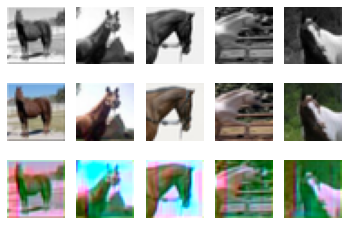

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

#batch size of 50 with 100 epochs seamed to work

### Part (e) [1 pt]
How does the performance of the cGAN compare with the autoencoder models that you tested in the first half of this assignment?

Answer: I used the Unet as my generator in Part B. Hence my generator is the same as Part A's Unet. However, the performance of my generator was not good, the loss fluctuated between 7 and 15 as epochs increase. The final loss of the generator is 11.9551, and the output image has pink and blue all over the place which are less similar to the original colored image.

### Part (f) [2 pt]

A colour space is a choice of mapping of colours into three-dimensional coordinates. Some colours could be close together in one colour space, but further apart in others. The RGB colour space is probably the most familiar to you, the model used in in our regression colourization example computes squared error in RGB colour space. But, most state of the art colourization models
do not use RGB colour space. How could using the RGB colour space be problematic? Your answer should relate how human perception of colour is different than the squared distance. You may use the Wikipedia article on colour space to help you answer the question.

Answer: RGB color space is limited in representing all spetrum of colors compared to human perception, since it is the combination of red, green and blue as the primary colors. These only form three dimensions to represent any particular colors. According to Wikipedia, the CIELAB color space is the usual reference standard, which is specifically designed to encompass all colors simiarl to human perception of color. 

CIELAB color space is formed by L* a* b*, which expresses color as three values: L* for perceptual lightness, and a* and b* for the four unique colors of human vision: red, green, blue, and yellow. Calculating the square distance, t CIELAB (closer to human perceptions) also incoprate lightness and yellow that RGB color space does not have.

## Part 2. Exploration [10 pt]

At this point we have trained a few different generative models for our image colourization task with varying results. What makes this work exciting is that there many other approaches we could take. In this part of the assignment you will be exploring at least one of several approaches towards improving our performance on the image colourization task. Some well known approaches you can consider include:

- lab colour space representation instead of RBG which simplifies the problem and requires you to predict two output channels instead of three
- k-means to represent RBG colourspace by 'k' distinct colours, this effectively changes the problem from regression to classification.

Other interesting approaches include:
- combining L1 loss along with the discriminator-based loss
- starting with a pretrained generator (i.e. Resnet)
- patch discriminator trained on local regions

A great example of some of these different approaches can be found in a <a href="https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8">blog post by Moein Shariatnia</a>.

Note you are only required to pick one of the suggested modifications.

In [ ]:
# provide your code here

# Patch Discriminator to train on local regions
import torch.nn.functional as F
class PatchDiscriminator(nn.Module):
    # used patch diciminator from Shariatnia's work
    def __init__(self, num_filters=32, n_down=3):
        super().__init__()
        model = [self.get_layers(4, num_filters, norm=False)] # input channel is 4 in our case
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

    def forward(self, x, img_greyscale):
        x = torch.cat([x, img_greyscale], axis=1)
        x = self.model(x)
        out = F.sigmoid(x)
        return out.squeeze()

In [ ]:
PatchDiscriminator()

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4):

In [ ]:
discriminator = PatchDiscriminator()
grey_input = torch.randn(16, 1, 32, 32)
rgb_input = torch.randn(16, 3, 32, 32)
out = discriminator(rgb_input,grey_input)
out.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([16, 2, 2])

In [ ]:
# modified train class in order to feed a different size (produced by patch 
# discriminator) into criterion

# added L1 norm penalty to discriminator's parameters to prevent patch 
# discriminator performs too well and generator cannot improve

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters, 1, num_in_channels)
        discriminator = PatchDiscriminator(args.num_filters, args.kernel) # PatchDiscriminator

    # LOSS FUNCTION
    criterion = nn.BCELoss()                                             
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            #--->ADDED 5
            img_grey = images
            img_real = labels
            batch_size = args.batch_size

            #discriminator training
            d_optimizer.zero_grad()
            
            # Loss for real images
            real_validity = discriminator(img_real, img_grey)
            real_class = Variable(torch.ones(real_validity.size()).cuda()) # change the real_class size
            real_loss = criterion(real_validity, real_class)

            # train with fake images
            fake_images = cnn(img_grey)
            fake_validity = discriminator(fake_images, img_grey)
            fake_class = Variable(torch.zeros(fake_validity.size()).cuda()) # change the fake_class size
            fake_loss = criterion(fake_validity, fake_class)
            l1_norm = sum(p.abs().sum() for p in discriminator.parameters()) #l1 norm
            d_loss = real_loss + fake_loss + args.l1_lambda*l1_norm #l1 norm

            d_loss.backward()
            d_optimizer.step()

            # generator training
            g_optimizer.zero_grad()

            fake_images = cnn(img_grey)
            validity = discriminator(fake_images, img_grey)
            g_class = Variable(torch.ones(validity.size()).cuda()) # change the g_class size
            g_loss = criterion(validity, g_class)
   
            g_loss.backward()
            g_optimizer.step()
        # print and visualize
        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())

        if epoch == args['epochs']-1:
            visual(images, labels, fake_images, args.gpu, 1)
        # if args.visualize:
        #     visual(images, labels, outputs, args.gpu, 1)   
    
    path = "l1_patchd_model_lr{0}_epoch{1}_bs{2}_lambda{3}.pt".format(args.learn_rate, 
                                                                     args.epochs, 
                                                                     args.batch_size, 
                                                                     args.l1_lambda)
    torch.save(cnn.state_dict(), path)

    return cnn

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 tensor(2.4924) tensor(1.8119)
1 tensor(7.7843) tensor(0.6043)
2 tensor(7.2960) tensor(0.4978)
3 tensor(7.6884) tensor(0.5221)
4 tensor(7.4922) tensor(0.3792)
5 tensor(6.3393) tensor(1.1904)
6 tensor(7.4282) tensor(0.6497)
7 tensor(7.2533) tensor(0.4541)
8 tensor(7.1565) tensor(0.3662)
9 tensor(6.0106) tensor(2.1406)
10 tensor(6.3361) tensor(1.0848)
11 tensor(5.4593) tensor(1.1034)
12 tensor(6.0945) tensor(0.7303)
13 tensor(6.4891) tensor(0.6874)
14 tensor(7.0105) tensor(0.5061)
15 tensor(7.2022) tensor(0.4087)
16 tensor(7.0139) tensor(0.3935)
17 tensor(5.3665) tensor(1.0310)
18 tensor(6.1831) tensor(0.6156)
19 tensor(5.8614) tensor(0.7334)
20 tensor(5.3902) tensor(0.7294)
21 tensor(5.9463) tensor(0.8218)
22 tensor(7.0987) tensor(0.6169)
23 tensor(7.3127) tensor(0.4722)
24 tensor(7.3524) tensor(0.3963)
25 tensor(6.9444) tensor(0.3456)
26 tensor(6.7771) tensor(0.3418)
27 tensor(6.9728) tensor(0.2901)
28 tensor(6.0166) tensor(0.5704)
29 tensor(6.8245) tensor(0.3219)
30 tensor(6.7665) te

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99 tensor(6.6550) tensor(0.2689)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


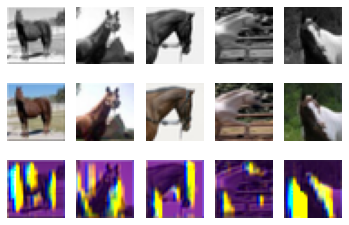

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
    "l1_lambda": 0.001 #l1 norm
}
args.update(args_dict)
cnn = train(args)
# final loss generator = 6.6550, discriminator loss = 0.2689 (better than the original model)
# colorization is not good, cannot even see horses

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 tensor(7.8400) tensor(0.8398)
1 tensor(8.2826) tensor(0.7000)
2 tensor(6.7691) tensor(0.7092)
3 tensor(8.0499) tensor(0.7552)
4 tensor(5.3070) tensor(2.0384)
5 tensor(7.4644) tensor(0.8273)
6 tensor(5.8402) tensor(1.3323)
7 tensor(5.8851) tensor(1.0935)
8 tensor(3.5416) tensor(1.6305)
9 tensor(7.2740) tensor(0.7096)
10 tensor(7.8348) tensor(0.9301)
11 tensor(7.3378) tensor(0.6429)
12 tensor(7.7614) tensor(1.0795)
13 tensor(7.3756) tensor(0.7364)
14 tensor(8.3089) tensor(0.4599)
15 tensor(5.6494) tensor(1.6786)
16 tensor(6.2862) tensor(0.8212)
17 tensor(6.5121) tensor(1.9803)
18 tensor(7.8605) tensor(0.6352)
19 tensor(4.6279) tensor(1.4232)
20 tensor(7.1142) tensor(0.7390)
21 tensor(5.7972) tensor(1.0386)
22 tensor(6.0169) tensor(0.7152)
23 tensor(4.2680) tensor(1.0551)
24 tensor(8.6896) tensor(0.4724)
25 tensor(7.7401) tensor(0.3734)
26 tensor(6.0759) tensor(0.8894)
27 tensor(7.7552) tensor(0.4704)
28 tensor(7.6513) tensor(0.3649)
29 tensor(6.5541) tensor(0.7675)
30 tensor(6.8632) te

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


79 tensor(7.4777) tensor(0.4717)


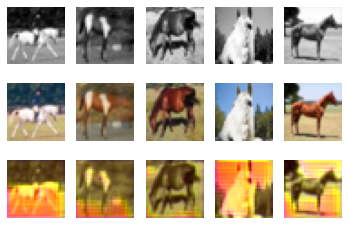

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.0005, 
    "batch_size": 30,
    "epochs": 80,
    "seed": 888,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
    "l1_lambda": 0.0005
}
args.update(args_dict)
cnn = train(args)
# slow down the learning rate
# Since part A shows unet performs better with smaller, so reduce batch size to 
# 30. Reduce number of epochs to prevent overfit to discriminator cause worse
# performance on generator
# since learning process will be slow, make lambda smaller to make weaker penalty
# increase number of filters to allow more parameters to process information
# final loss generator = 7.4777,  discriminator loss = 0.4717 (slighly worse generator 
# performance from previous model, worse discriminator performance)
# colorization is not very good, but it captures some yellow ground from the original rgb images.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 tensor(10.2371) tensor(0.4331)
1 tensor(8.8459) tensor(0.5167)
2 tensor(5.2246) tensor(0.9323)
3 tensor(4.5598) tensor(0.8294)
4 tensor(7.4372) tensor(0.4296)
5 tensor(5.8763) tensor(0.7553)
6 tensor(8.9892) tensor(0.5536)
7 tensor(9.2346) tensor(0.6619)
8 tensor(9.0587) tensor(0.6586)
9 tensor(8.6929) tensor(0.7303)
10 tensor(11.3929) tensor(0.6408)
11 tensor(8.3105) tensor(0.4242)
12 tensor(6.6739) tensor(0.4174)
13 tensor(8.5387) tensor(0.4208)
14 tensor(7.8804) tensor(0.4617)
15 tensor(8.0272) tensor(0.4150)
16 tensor(9.8561) tensor(0.2712)
17 tensor(8.6124) tensor(0.2833)
18 tensor(6.8727) tensor(0.4651)
19 tensor(7.8906) tensor(0.4069)
20 tensor(5.4719) tensor(0.5485)
21 tensor(6.7724) tensor(0.3969)
22 tensor(9.6270) tensor(0.2371)
23 tensor(8.8986) tensor(0.1826)
24 tensor(8.7664) tensor(0.1509)
25 tensor(8.3601) tensor(0.1302)
26 tensor(7.9747) tensor(0.1135)
27 tensor(8.1870) tensor(0.3604)
28 tensor(6.4703) tensor(0.3885)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29 tensor(1.0899) tensor(1.7516)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


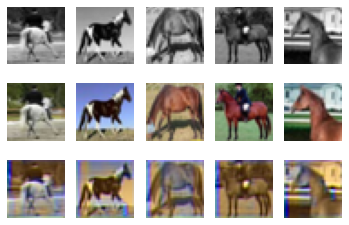

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 15,
    "epochs": 30,
    "seed": 666,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
    "l1_lambda": 0.0005
}
args.update(args_dict)
cnn = train(args)
# reduce the batch size, since in PartA Unet performance becomes better as batch size decreases
# use less number of epochs to prevent discriminator being too good cause generator cannot learn
# final loss generator = 1.0899, discriminator loss = 1.7516 (the best generator although 
# discriminator's performance is worse)
# colorization is better, it can capture brown and white very well 

## Part 3. New Data [5 pt]
Retrieve sample pictures from online and demonstrate how well your best model performs. Provide all your code.

In [ ]:
# provide your code here
from google.colab import drive
drive.mount('/content/drive')
# my images folder: https://drive.google.com/drive/folders/1jMbEgGKnPDHxr31QV5E28OoFXRXCDYLn?usp=sharing
# 8 pictures of cat, 8 pictures of dogs, 8 pictures of rabbit and 8 of penguins

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets

def get_data_loader(batch_size = 64):
    torch.manual_seed(100)
    np.random.seed(100)

    # Transform all image size into 32x32, and into tensor
    transform = transforms.Compose(
            [transforms.Resize([32,32]),
             transforms.ToTensor()])
    
    # Load data
    dataset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/MASc First Year/MIE1517/Lab3/images", transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    
    return data_loader

# convert colour images into greyscale
def animal_process(xs, ys, max_pixel=256.0, downsize_input=False):
    # xs = xs / max_pixel
    # npr.shuffle(xs)
    grey_xs = xs.numpy() # convert tensor into array
    grey = np.mean(grey_xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)

def new_get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float() # only convert xs which is the array into tensor
    # ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    # return Variable(xs), Variable(ys)
    return Variable(xs), ys

def animal_visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):
  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:8, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:8, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:8, :, :, :], [0, 2, 3, 1])

  fig = plt.figure(figsize=(12,5))
  for i in range(8):
      ax = plt.subplot(3, 8, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 8, i + 1 + 8)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 8, i + 1 + 16)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

In [ ]:
def evaluate(args, gen):
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    criterion = nn.MSELoss()
    print("Loading data...")
    data = get_data_loader(batch_size = args.batch_size) # as long as the batch size is very large, all images will go into one batch

    for images, labels in data:
        (x_train, y_train) = images, labels # all images in the first batch passes into x_train

    print("Transforming data...")
    train_rgb, train_grey = animal_process(x_train, y_train, downsize_input=args.downsize_input) # turn into grey

    print("Beginning training ...")
    gen.eval()

    if args.gpu:
        gen.cuda()

    images, labels = new_get_torch_vars(train_grey, train_rgb, args.gpu)

        #--->ADDED 5
    img_grey = images
    img_real = labels
    fake_images = gen(img_grey)
    loss = criterion(fake_images, img_real)
    # since there is only one batch, no need to loop over, simply calculate the loss of the only batch

    animal_visual(images, labels, fake_images, args.gpu, 1)

    return loss

Loading data...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Transforming data...
Beginning training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


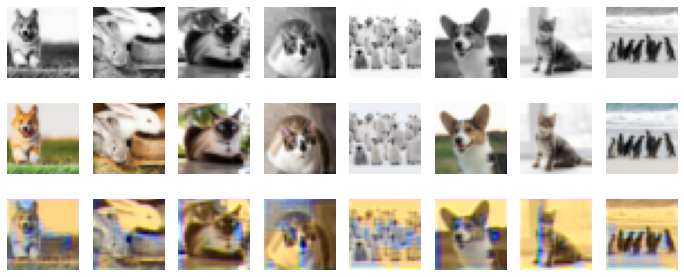

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
# cnn = train(args)
num_in_channels = 1 if not args.downsize_input else 3
gen = Generator(args.kernel, args.num_filters, 1, num_in_channels)
gen.load_state_dict(torch.load("l1_patchd_model_lr0.001_epoch30_bs15_lambda0.0005.pt"))
test = evaluate(args,gen)

In [ ]:
print('test performance MSE: {} '.format(test))
# Final MSE reaches 0.03. Similar to the results from training, this model captures
# yellow, brown, and white quite well, since animal's fur are common in yellow, brown and white. 

test performance MSE: 0.02659783884882927 


#### Using same cifar10 - only load cat category

In [ ]:
CAT_CATEGORY = 3

# convert colour images into greyscale
def cat_process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == CAT_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)

# visualize 10 train/test images
def cat_visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):
  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:8, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:8, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:8, :, :, :], [0, 2, 3, 1])

  fig = plt.figure(figsize=(12,5))
  for i in range(8):
      ax = plt.subplot(3, 8, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 8, i + 1 + 8)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 8, i + 1 + 16)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

In [ ]:
def evaluate(args, gen):
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    criterion = nn.MSELoss()
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = cat_process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = cat_process(x_test, y_test, downsize_input=args.downsize_input)

    print("Beginning training ...")
    gen.eval()

    if args.gpu:
        gen.cuda()
    
    n = 0 
    iters, losses = [], []
    for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)

        #--->ADDED 5
        img_grey = images
        img_real = labels
        fake_images = gen(img_grey)
        loss = criterion(fake_images, img_real)
        iters.append(n)
        losses.append(float(loss)/args.batch_size)
        n += 1

    cat_visual(images, labels, fake_images, args.gpu, 1)
    return np.mean(losses)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


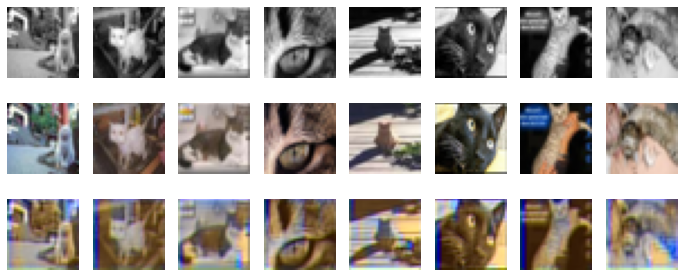

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
# cnn = train(args)
num_in_channels = 1 if not args.downsize_input else 3
gen = Generator(args.kernel, args.num_filters, 1, num_in_channels)
gen.load_state_dict(torch.load("l1_patchd_model_lr0.001_epoch30_bs15_lambda0.0005.pt"))
test = evaluate(args, gen)

In [ ]:
print('test performance MSE: {} '.format(test))
# Since this model captures yellow, brown and white very well. And usually 
# animal's fur are common in yellow, brown and white. Its performance in 
# colorizing animals is very good. MSE = 0.0004.

test performance MSE: 0.0003538065567612648 


### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [1]:
%%shell
jupyter nbconvert --to html LAB_3_Generating_Data.ipynb

[NbConvertApp] Converting notebook LAB_3_Generating_Data.ipynb to html
[NbConvertApp] Writing 2914111 bytes to LAB_3_Generating_Data.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus